# Analysis of Expletives in Song Lyrics by Decade

## How has the frequency of explicit/"toxic" language in song lyrics changed by decade?

### Load libraries

In [21]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from scipy.spatial.distance import cosine
import torch
from transformers import BertTokenizer
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

In [2]:
!pip install transformers
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sydney/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data and prep it for analysis

In [3]:
df = pd.read_csv('data/billboard-lyrics-spotify.csv', sep=',', header=0)
df.head(2)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
0,percy faith,percy faith,1,theme from a summer place,1960,NaN,theme from a summer place,percy faith,theres a summer place where it may rain or sto...,0.631,...,0.0253,92.631,4.0,0.749,2.414883,104.0,0.717771,58.0,1960,1.793103
1,jim reeves,jim reeves,2,he'll have to go,1960,NaN,hell have to go,jim reeves,put your sweet lips a little closer to the pho...,0.909,...,0.0379,81.181,3.0,0.200,2.310667,152.0,1.096365,69.0,1960,2.202899


In [4]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df['decade'] = df['year'].dt.year // 10 * 10

In [5]:
df.dropna(subset=['lyrics'], inplace=True)


In [6]:
grouped_df = df.groupby('decade')
display(grouped_df['lyrics'].count())

decade
1960    975
1970    986
1980    994
1990    933
2000    919
2010    709
Name: lyrics, dtype: int64

In [7]:
# inspect data from songs released 2010-2019
grouped_df.get_group(2010)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
4850,kesha,kesha,1,tik tok,2010-01-01,NaN,tik tok,kesha,grab my glasses im out the door im gonna hit ...,0.07460,...,0.1160,120.032,4.0,0.735,3.328217,458.0,2.293521,136.0,2010,3.367647
4851,lady antebellum,lady antebellum,2,need you now,2010-01-01,NaN,need you now,lady antebellum,picture perfect memories scattered all around...,0.09270,...,0.0303,107.943,4.0,0.231,4.626217,215.0,0.774571,77.0,2010,2.792208
4852,train,train,3,"hey, soul sister",2010-01-01,NaN,hey soul sister,train,heyy heeey heey your lipstick stains on the f...,0.21700,...,0.0436,97.030,4.0,0.768,3.611117,284.0,1.310767,115.0,2010,2.469565
4853,katy perry featuring snoop dogg,katy perry,4,california gurls,2010-01-01,snoop dogg,california gurls,katy perry,greetings loved ones lets take a journey i kn...,0.00446,...,0.0569,125.014,4.0,0.425,3.910883,445.0,1.896417,162.0,2010,2.746914
4854,usher featuring will.i.am,usher,5,omg,2010-01-01,will.i.am,omg,usher,oh my gosh baby let me i did it again so im g...,0.19800,...,0.0332,129.998,4.0,0.326,4.491550,526.0,1.951813,105.0,2010,5.009524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5561,camila cabello featuring young thug,camila cabello,96,havana,2017-01-01,young thug,havana,camila cabello,hey half of my heart is in havana ooh na na h...,0.18400,...,0.0300,104.988,4.0,0.394,3.621783,350.0,1.610625,102.0,2010,3.431373
5562,maroon 5 featuring sza,maroon 5,97,what lovers do,2017-01-01,sza,what lovers do,maroon 5,say say say hey hey now baby oh mama dont pla...,0.08050,...,0.0693,109.959,4.0,0.420,3.330817,366.0,1.831383,75.0,2010,4.880000
5563,blackbear,blackbear,98,do re mi,2017-01-01,NaN,do re mi,blackbear,do re mi fa so yeah yeah yeah oh do re mi fa ...,0.00419,...,0.0465,110.977,3.0,0.154,3.533783,382.0,1.801657,122.0,2010,3.131148
5564,xxxtentacion,xxxtentacion,99,look at me!,2017-01-01,NaN,look at me,xxxtentacion,ayy im like bitch who is your mans ayy cant k...,0.25900,...,0.2820,139.059,4.0,0.349,2.105767,337.0,2.667279,106.0,2010,3.179245


In [8]:
df.dropna(subset=['lyrics'], inplace=True)

6

### Prep lyrics for analysis

In [9]:
# group song lyrics based on decade they're in
grouped_lyrics = {}
for decade, group in grouped_df:
    lyrics = [item for item in group['lyrics']]
    grouped_lyrics[decade] = lyrics

In [10]:
# break song lyrics into their individual words
# df['lyrics']
lyrics = [item for item in df['lyrics']]
lyrics_strings = list(map(str, lyrics))
lyrics_words = [word_tokenize(item) for item in lyrics_strings]

#### Song lyric statistics

In [11]:
word_counts = [len(item) for item in lyrics_words] # count of words in each song
avg_word_counts = np.mean(word_counts) # get the average count of words per song
min_words = np.min(word_counts) # get the minimum words per song
max_words = np.max(word_counts) # get the maximum words per song
print('Average number of words per song: {}'.format(avg_word_counts))
print('Minimum number of words per song: {}'.format(min_words))
print('Maximum number of words per song: {}'.format(max_words))

Average number of words per song: 306.1104060913706
Minimum number of words per song: 0
Maximum number of words per song: 1153


#### Set lyrics to lowercase, remove punctuation and stopwords, then stem them

In [12]:
sw = set(stopwords.words('english'))
lowercased = [[word.lower() for word in item] for item in lyrics_words]
removed_punctuation = [[word for word in review if word.isalnum()] for review in lowercased]
removed_stopwords = [[word for word in review if word not in sw] for review in removed_punctuation]

ps = PorterStemmer()
stemmed = [[ps.stem(word) for word in review] for review in removed_stopwords]

from nltk.util import ngrams

unigrams = [list(ngrams(item, 1)) for item in removed_stopwords]
bigrams = [list(ngrams(item, 2)) for item in removed_punctuation]
trigrams = [list(ngrams(item, 3)) for item in removed_punctuation]


In [13]:
# calculate top n-grams
def get_ngrams(list):
    counts = {}
    for song in list:
        for ngram in song:
            if ngram in counts.keys():
                counts[ngram] += 1
            else:
                counts[ngram] = 1

    return sorted(counts.items(), key=lambda x:x[1], reverse=True)

top_unigrams = get_ngrams(unigrams)
top_bigrams = get_ngrams(bigrams)
top_trigrams = get_ngrams(trigrams)

print(top_unigrams[:5])
print(top_bigrams[:5])
print(top_trigrams[:5])

[(('love',), 15698), (('im',), 15131), (('dont',), 12034), (('know',), 11768), (('na',), 11229)]
[(('in', 'the'), 5859), (('wan', 'na'), 4768), (('and', 'i'), 4248), (('gon', 'na'), 4244), (('i', 'know'), 3533)]
[(('oh', 'oh', 'oh'), 2136), (('la', 'la', 'la'), 1856), (('i', 'wan', 'na'), 1681), (('na', 'na', 'na'), 1347), (('i', 'love', 'you'), 1190)]


### Import toxic BERT model

In [14]:
# load tokenizer (same one trained with the model)
tokenizer = BertTokenizer.from_pretrained("unitary/toxic-bert")

model = SentenceTransformer('unitary/toxic-bert')

No sentence-transformers model found with name /Users/sydney/.cache/torch/sentence_transformers/unitary_toxic-bert. Creating a new one with MEAN pooling.


#### Get decade embeddings to determine cosine similarity between "toxic" lyrics of each decade

In [15]:
decade_embeddings = {}

for decade in grouped_lyrics:
    songs = grouped_lyrics[decade]
    decade_embeddings[decade] = model.encode(songs, convert_to_tensor=True)

In [16]:
decade_mean = {}
for decade in decade_embeddings:
    decade_mean[decade] = torch.mean(decade_embeddings[decade], axis=0)

In [17]:
list(decade_mean.values())
array_decade_mean = torch.stack(list(decade_mean.values()))
np_means = array_decade_mean.numpy()

In [18]:
cossim = util.cos_sim(np_means, np_means)

In [66]:
print(len(decade_embeddings[1960]))
print(len(decade_embeddings[1970]))
print(len(decade_embeddings[1980]))
print(len(decade_embeddings[1990]))
print(len(decade_embeddings[2000]))
print(len(decade_embeddings[2010]))

print(str(975+986+994+933+919+709))

975
986
994
933
919
709
5516


In [62]:
num_songs = 0
total_dimensions = 0

for decade in decade_embeddings:
    num_songs += len(decade_embeddings[decade])
    for i in range(len(decade_embeddings[decade])):
        total_dimensions += len(decade_embeddings[decade][i])

print(f'Toxic BERT produced embeddings for {num_songs} songs.')
print(f'average number of dimensions per song is {total_dimensions/num_songs}')

Toxic BERT produced embeddings for 5516 songs.
average number of dimensions per song is 768.0


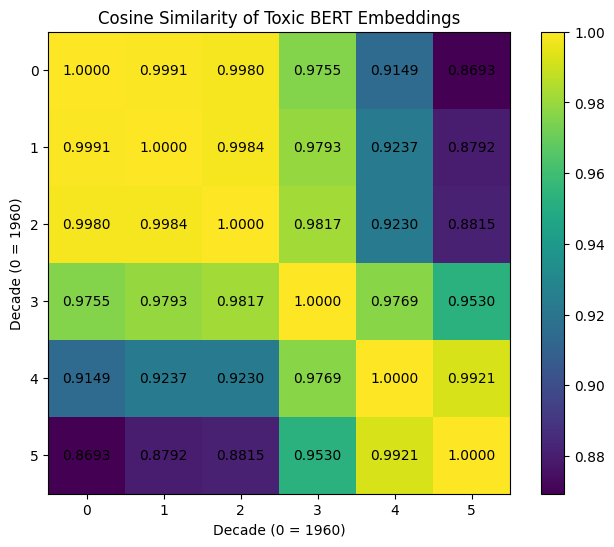

In [22]:
# Plot the cosine similarity matrix as a heatmap
axes = [1960, 1970, 1980, 1990, 2000, 2010]
plt.figure(figsize=(8, 6))
plt.imshow(cossim, cmap='viridis', interpolation='nearest')
plt.title('Cosine Similarity of Toxic BERT Embeddings')
plt.colorbar()
plt.xlabel('Decade (0 = 1960)')
plt.ylabel('Decade (0 = 1960)')

# Annotate the plot with actual values
for i in range(cossim.shape[0]):
    for j in range(cossim.shape[1]):
        plt.text(j, i, f'{cossim[i, j]:.4f}', ha='center', va='center', color='black')

plt.show()

### Load in list of "bad words" as collected by Carnegie Mellon CS

In [ ]:
# list of ~1400 swear words
# https://www.cs.cmu.edu/~biglou/resources/bad-words.txt

cuss = open("data/bad-words.txt", "r") 
data = cuss.read()
cuss_list = data.split("\n") 
cuss.close() 

print(cuss_list)
print(len(cuss_list))

['abbo', 'abo', 'abortion', 'abuse', 'addict', 'addicts', 'adult', 'africa', 'african', 'alla', 'allah', 'alligatorbait', 'amateur', 'american', 'anal', 'analannie', 'analsex', 'angie', 'angry', 'anus', 'arab', 'arabs', 'areola', 'argie', 'aroused', 'arse', 'arsehole', 'asian', 'ass', 'assassin', 'assassinate', 'assassination', 'assault', 'assbagger', 'assblaster', 'assclown', 'asscowboy', 'asses', 'assfuck', 'assfucker', 'asshat', 'asshole', 'assholes', 'asshore', 'assjockey', 'asskiss', 'asskisser', 'assklown', 'asslick', 'asslicker', 'asslover', 'assman', 'assmonkey', 'assmunch', 'assmuncher', 'asspacker', 'asspirate', 'asspuppies', 'assranger', 'asswhore', 'asswipe', 'athletesfoot', 'attack', 'australian', 'babe', 'babies', 'backdoor', 'backdoorman', 'backseat', 'badfuck', 'balllicker', 'balls', 'ballsack', 'banging', 'baptist', 'barelylegal', 'barf', 'barface', 'barfface', 'bast', 'bastard ', 'bazongas', 'bazooms', 'beaner', 'beast', 'beastality', 'beastial', 'beastiality', 'beato

In [ ]:
# display(grouped_lyrics[1960])
def get_decade_swears(decade):
    swears = []

    for lyrics in grouped_lyrics[decade]:
        for word in lyrics.split():
            if word in cuss_list:
                swears.append(word)
    
    counts = {}
    for word in swears:
        if word in counts.keys():
            counts[word] += 1
        else:
            counts[word] = 1
    
    return counts

swears_1960 = get_decade_swears(1960)
swears_1970 = get_decade_swears(1970)
swears_1980 = get_decade_swears(1980)
swears_1990 = get_decade_swears(1990)
swears_2000 = get_decade_swears(2000)
swears_2010 = get_decade_swears(2010)

### Wordclouds of the most commonly identified "bad words" in songs released in each decade

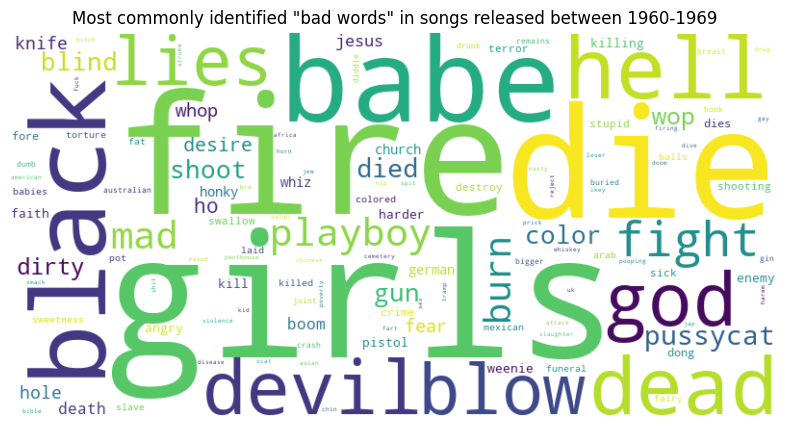

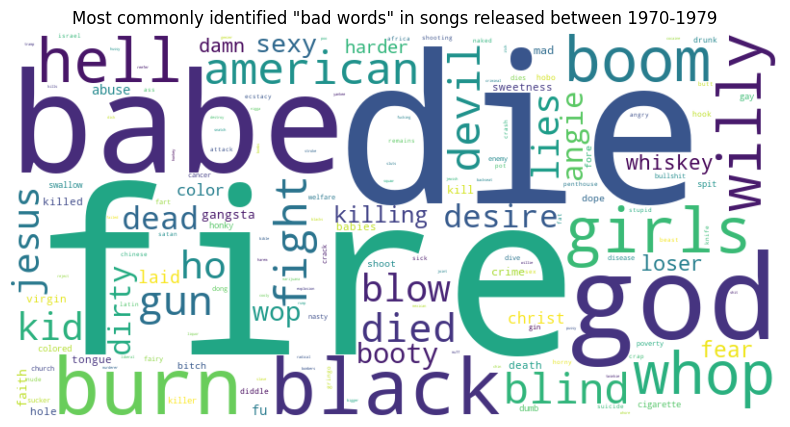

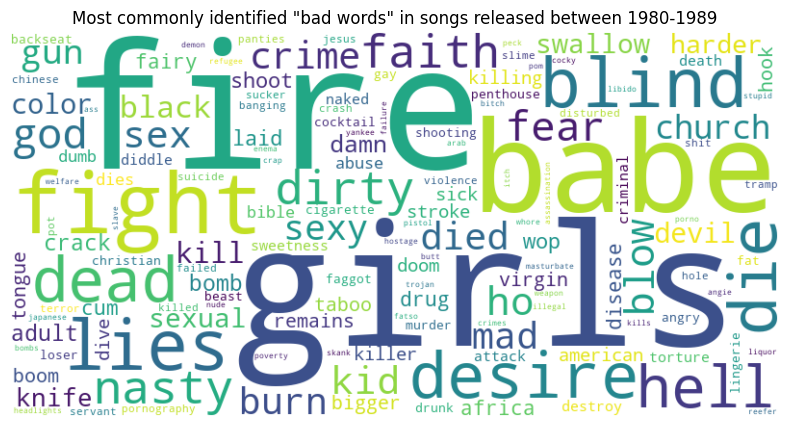

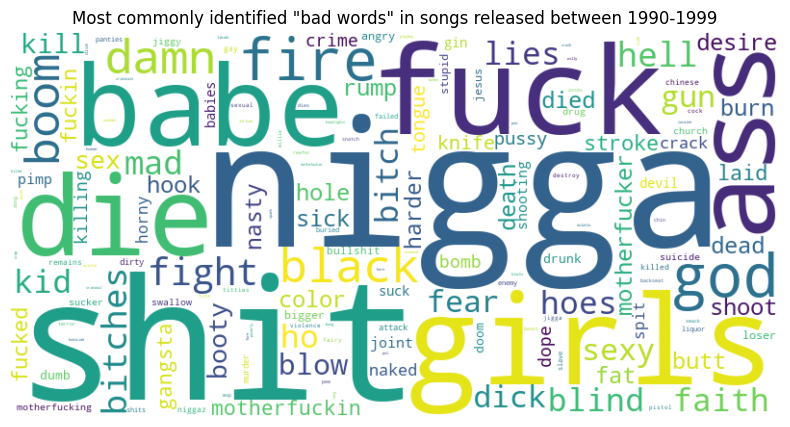

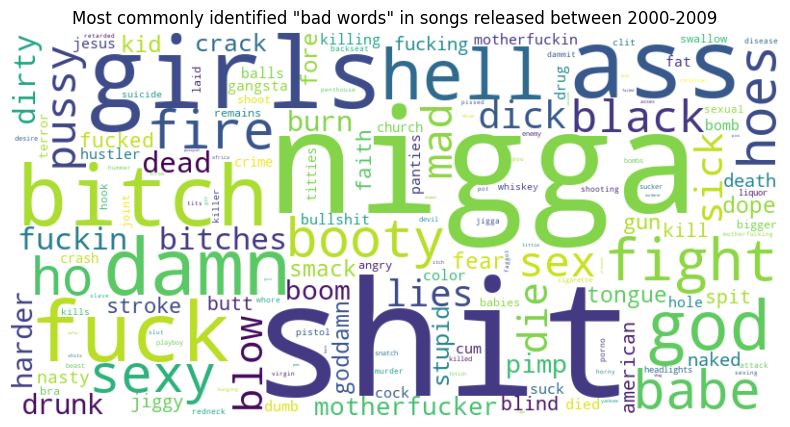

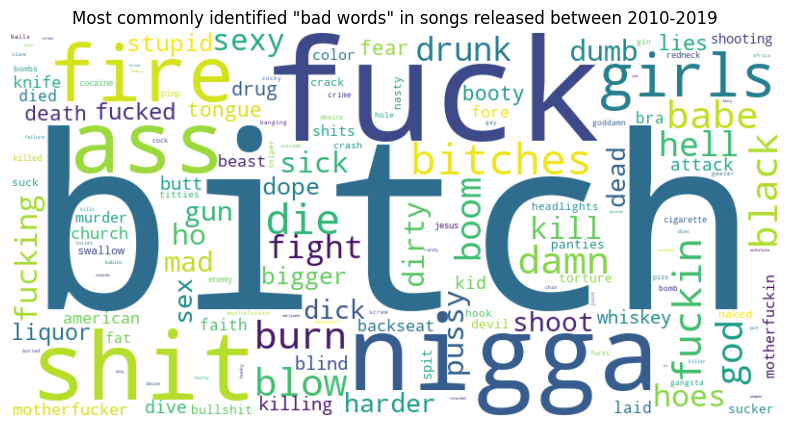

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(swears_1960)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most commonly identified "bad words" in songs released between 1960-1969')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(swears_1970)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most commonly identified "bad words" in songs released between 1970-1979')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(swears_1980)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most commonly identified "bad words" in songs released between 1980-1989')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(swears_1990)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most commonly identified "bad words" in songs released between 1990-1999')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(swears_2000)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most commonly identified "bad words" in songs released between 2000-2009')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(swears_2010)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most commonly identified "bad words" in songs released between 2010-2019')
plt.show()

### Reducing the dimensionality using PCA to plot KMeans clustering of BERT embeddings

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Assuming bert_embeddings is a NumPy array or a pandas DataFrame containing BERT embeddings
pca_decade_embeddings = decade_embeddings.copy()

# Initialize PCA with desired number of components
num_components = 300  # Number of components to keep after dimensionality reduction
pca = PCA(num_components)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])

# Fit PCA on the BERT embeddings
for decade in pca_decade_embeddings:
    embeddings = pca_decade_embeddings[decade]
    # Transform the embeddings to the lower-dimensional space
    # reduced_embeddings = pipe.fit_transform(embeddings)
    reduced_embeddings = pipe.fit_transform(embeddings)
    pca_decade_embeddings[decade] = reduced_embeddings

# Check the shape of the reduced embeddings
print(f'number of songs in 2010 decade: {len(pca_decade_embeddings[2010])}')
print(f'number of dimensions representing the first song in 2010 decade: {len(pca_decade_embeddings[2010][0])}')

number of songs in 2010 decade: 709
number of dimensions representing the first song in 2010 decade: 300


/Users/sydney/opt/anaconda3/envs/info498b/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sydney/opt/anaconda3/envs/info498b/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sydney/opt/anaconda3/envs/info498b/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sydney/opt/anaconda3/envs/info498b/lib/python3.11/site-packages/sklearn/cluster/_kme

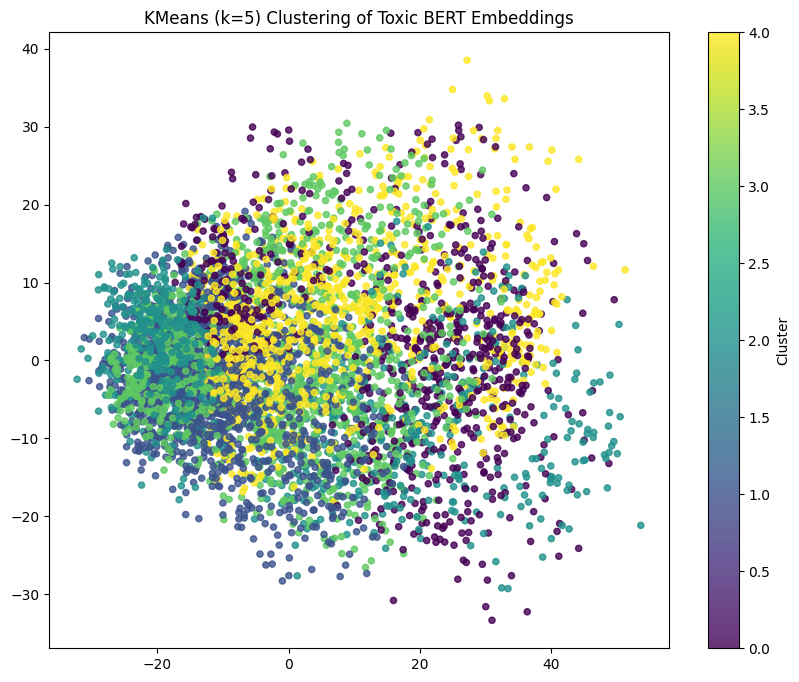

In [70]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Each decade contains a list of song embeddings

# Initialize KMeans with the desired number of clusters
num_clusters = 5  # Number of clusters
kmeans_dict = {}

# Iterate through each decade
for decade, embeddings_reduced in pca_decade_embeddings.items():
    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings_reduced)
    
    # Initialize KMeans for the current decade
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    # Fit KMeans to the embeddings for the current decade
    kmeans.fit(embeddings_array)
    
    # Store the KMeans model for the current decade
    kmeans_dict[decade] = kmeans

# Plot clusters for each decade
plt.figure(figsize=(10, 8))

# Iterate through each decade and plot the clusters
for decade, kmeans in kmeans_dict.items():
    embeddings_reduced = pca_decade_embeddings[decade]
    cluster_labels = kmeans.labels_

    # Extract the first two dimensions for plotting
    x = embeddings_reduced[:, 0]  # First dimension
    y = embeddings_reduced[:, 1]  # Second dimension

    # Plot the points for the current decade, color-coded based on the cluster labels
    plt.scatter(x, y, label=f'Decade {decade}', c=cluster_labels, cmap='viridis', s=20, alpha=0.8)

# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
plt.title('KMeans (k=5) Clustering of Toxic BERT Embeddings')
plt.colorbar(label='Cluster')
# plt.legend()
plt.show()
